In [7]:
#  add karna-python-backend to the path
import sys
sys.path.append('C:/Users/Prince/Documents/GitHub/Proejct-Karna/offline-ai-assistant/karna-python-backend')

from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [8]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



c:\Users\Prince\Documents\GitHub\Proejct-Karna\offline-ai-assistant\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [10]:
# reload utils
import importlib
# import utils
# importlib.reload(utils)
import os
from config.paths import workspace_data_dir
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = os.path.join(workspace_data_dir, 
                          'youtube.com/123e4567-e89b-12d3-a456-426614174000/screenshots/raw/screenshot_20250305_145412_984550.png'
                          )

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=False)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1920, 1080)

0: 736x1280 123 icons, 83.0ms
Speed: 17.3ms preprocess, 83.0ms inference, 114.7ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 162 91


c:\Users\Prince\Documents\GitHub\Proejct-Karna\offline-ai-assistant\venv\lib\site-packages\transformers\generation\configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


time to get parsed content: 0.7835061550140381


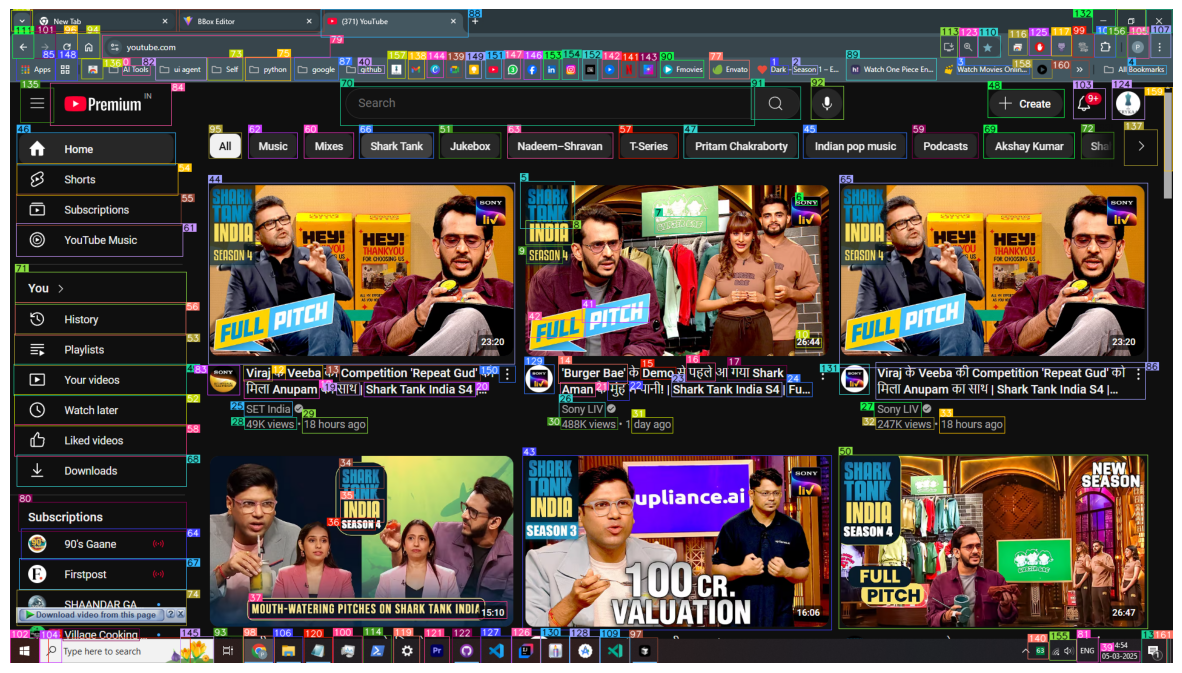

In [11]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [12]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.0963541641831398, 0.08611111342906952, 0.12...",False,Al Tools,box_ocr_content_ocr,0
1,text,"[0.6536458134651184, 0.08611111342906952, 0.66...",False,Dark,box_ocr_content_ocr,1
2,text,"[0.6723958253860474, 0.08611111342906952, 0.69...",False,Season,box_ocr_content_ocr,2
3,text,"[0.8140624761581421, 0.08611111342906952, 0.87...",False,Watch Movies Onlin .,box_ocr_content_ocr,3
4,text,"[0.9609375, 0.08611111342906952, 0.99427086114...",False,Bookmarks,box_ocr_content_ocr,4
...,...,...,...,...,...,...
157,icon,"[0.32459336519241333, 0.07620593905448914, 0.3...",True,Account,box_yolo_content_yolo,157
158,icon,"[0.878950297832489, 0.0773911401629448, 0.8960...",True,Play button,box_yolo_content_yolo,158
159,icon,"[0.9922330975532532, 0.11955365538597107, 1.0,...",True,a folder.,box_yolo_content_yolo,159
160,icon,"[0.912218451499939, 0.07928596436977386, 0.927...",True,Previous,box_yolo_content_yolo,160


In [13]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.0963541641831398,
   0.08611111342906952,
   0.12031249701976776,
   0.10092592239379883],
  'interactivity': False,
  'content': 'Al Tools',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.6536458134651184,
   0.08611111342906952,
   0.6692708134651184,
   0.09907407313585281],
  'interactivity': False,
  'content': 'Dark',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.6723958253860474,
   0.08611111342906952,
   0.6942708492279053,
   0.09907407313585281],
  'interactivity': False,
  'content': 'Season',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.8140624761581421,
   0.08611111342906952,
   0.8765624761581421,
   0.09907407313585281],
  'interactivity': False,
  'content': 'Watch Movies Onlin .',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.9609375,
   0.08611111342906952,
   0.9942708611488342,
   0.09907407313585281],
  'interactivity': False,
  'content': 'Bookmarks